# 🧠 EXIST 2025 - Subtask 1.1: Clasificación Binaria con Soft Labels

Este notebook implementa un **enfoque híbrido innovador** para la Subtask 1.1 de EXIST 2025 combinando:

## 🎯 **Objetivo Principal**
Desarrollar un clasificador binario de sexismo en tweets usando **soft labels** de 6 anotadores para capturar la subjetividad inherente en la tarea.

## 🚀 **Optimizado para Azure ML**
- ✅ **Azure ML Compute Instance** (Standard_F16s_v2: 16 vCPUs, 32GB RAM)
- ✅ **CPU-optimized training** con paralelización avanzada
- ✅ **Gestión automática de recursos** y monitoreo de costos
- ✅ **Integración nativa** con Azure ML Studio

## 🔧 **Características Técnicas**

### 📊 **Modelo y Datos**
- **Modelo Base:** `microsoft/mdeberta-v3-base` (multilingüe ES/EN)
- **Soft Labels:** Probabilidades basadas en consenso de 6 anotadores
- **Dataset:** EXIST 2025 con preprocesamiento especializado para redes sociales

### ⚡ **Optimizaciones Azure ML**
- **Congelamiento inteligente:** Embeddings + primeras 6 capas encoder
- **Batch processing:** Optimizado para instancias F16s_v2
- **Paralelización:** 8 workers para máximo throughput
- **Monitoreo:** Recursos, tiempo y costos en tiempo real

### 🛠️ **Pipeline Completo**
1. **Preprocesamiento** → Limpieza, emojis, contracciones españolas
2. **Tokenización** → MDeBERTa tokenizer con padding optimizado
3. **Entrenamiento** → Soft labels con BCE loss y early stopping
4. **Evaluación** → F1, accuracy, y métricas especializadas
5. **Deployment** → Preparado para Azure ML endpoints

---

**🚀 ¡Listo para ejecutar en Azure ML Compute Instance!**

In [84]:
import torch

# Detectar si hay una GPU disponible (CUDA) y seleccionarla, de lo contrario, usar CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Dispositivo seleccionado: {device}")

if torch.cuda.is_available():
    print(f"🔥 Nombre de la GPU: {torch.cuda.get_device_name(0)}")

✅ Dispositivo seleccionado: cuda
🔥 Nombre de la GPU: NVIDIA GeForce RTX 4080 Laptop GPU


In [85]:
#pip install numpy pandas emoji torch transformers datasets scikit-learn matplotlib seaborn scipy psutil tiktoken tokenizer 
#pip install protobuf sentencepiece
#pip install accelerate -U

In [86]:
import numpy as np
print(np.__version__)

2.0.2


In [87]:
# 🔍 VERIFICACIÓN DEL ENTORNO  ML
import os
import subprocess

print("🔍 VERIFICANDO ENTORNO DE EJECUCIÓN:")
print("="*50)

# Verificar si estamos en Azure ML
if os.path.exists('/opt/miniconda/envs/azureml_py38/'):
    print("✅ Azure ML Compute Instance detectado")
    print("   📍 Entorno: Azure ML Studio")
elif os.path.exists('/home/azureuser/'):
    print("✅ Azure ML environment detectado")
    print("   📍 Entorno: Azure ML Compute")
else:
    print("❓ Entorno local o desconocido")

# Verificar directorio actual
current_dir = os.getcwd()
print(f"📂 Directorio actual: {current_dir}")

# Verificar si existe el repositorio Git
git_root = "/home/azureuser/cloudfiles/code"
if os.path.exists(f"{git_root}/.git"):
    print(f"✅ Repositorio Git encontrado en: {git_root}")
    
    # Verificar archivos del proyecto
    data_file = f"{git_root}/src/data/EXIST2025_training.json"
    if os.path.exists(data_file):
        print("✅ Archivo de datos EXIST2025 encontrado")
    else:
        print("⚠️  Archivo de datos EXIST2025 no encontrado")
        print(f"   Buscado en: {data_file}")
else:
    print("❌ Repositorio Git no encontrado")

# Verificar recursos disponibles
import psutil
cpu_count = psutil.cpu_count()
memory_gb = psutil.virtual_memory().total / (1024**3)
print(f"💻 Recursos disponibles:")
print(f"   🔥 CPU cores: {cpu_count}")
print(f"   🧠 RAM total: {memory_gb:.1f} GB")

print("="*50)

🔍 VERIFICANDO ENTORNO DE EJECUCIÓN:
❓ Entorno local o desconocido
📂 Directorio actual: /home/luisa-fernanda/Descargas/sre
❌ Repositorio Git no encontrado
💻 Recursos disponibles:
   🔥 CPU cores: 32
   🧠 RAM total: 31.0 GB


In [88]:
# IMPORTACIONES OPTIMIZADAS PARA AZURE ML + CPU
import pandas as pd
import json
import re
import unicodedata
import emoji
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Transformers y PyTorch (ya disponibles en Azure ML)
from transformers import AutoTokenizer, AutoModel, AutoConfig, TrainingArguments, Trainer,EarlyStoppingCallback
from transformers.modeling_outputs import SequenceClassifierOutput
from datasets import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F

# Sklearn (ya disponible en Azure ML)
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score
)
from sklearn.model_selection import train_test_split

# Visualización (ya disponibles)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import ast

# Sistema y monitoreo
import os
import time
import psutil

# Configurar PyTorch para CPU
#torch.set_num_threads(4)  # Ajustar según tu instancia Azure ML
#print("✅ Importaciones optimizadas para Azure ML + CPU")
print(f"🔥 PyTorch CPU configurado: {torch.get_num_threads()} threads")
print(f"📊 Versión transformers: {__import__('transformers').__version__}")

🔥 PyTorch CPU configurado: 24 threads
📊 Versión transformers: 4.55.4


In [89]:
import time
import os
import psutil
import torch

class TrainingManager:
    """
    Una clase para gestionar la configuración, rutas y monitoreo
    de un ciclo de entrenamiento en un entorno con GPU.
    """
    def __init__(self):
        # Inicia el cronómetro en cuanto se crea el objeto
        self.start_time = time.time()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.paths = self.setup_paths()
        self.print_environment_summary()

    def setup_paths(self):
        """Configura y crea las rutas necesarias para el proyecto."""
        print("📁 Configurando rutas de trabajo...")
        project_root = "./"
        paths = {
            'output_dir': os.path.join(project_root, "results_hybrid"),
            'logging_dir': os.path.join(project_root, "logs_hybrid"),
            'model_save_path': os.path.join(project_root, "model_hybryd"),
            'data_path': os.path.join(project_root, "src/data")
        }
        for path in paths.values():
            os.makedirs(path, exist_ok=True)

        print(f"   - Directorio de salida: {paths['output_dir']}")
        return paths

    def get_training_config(self):
        """Devuelve un diccionario con hiperparámetros optimizados para GPU."""
        print("\n⚙️  hiperparámetros para entrenamiento...")
        config = {
            'batch_size': 8,#32          # Aumentado para aprovechar la VRAM
            'num_epochs': 5,
            'learning_rate': 2e-5,
            'warmup_steps': 150,
            'dataloader_num_workers': 4, # Un valor seguro y eficiente para GPU
            'max_length': 128,
            'gradient_accumulation_steps': 4, #1
            'dropout': 0.3,
            'layer_frozen': 4
        }
        # Imprime la configuración para que la verifiques
        for key, value in config.items():
            print(f"   - {key}: {value}")
        return config

    def report_training_summary(self):
        """Calcula e imprime un resumen del tiempo de entrenamiento."""
        runtime_minutes = (time.time() - self.start_time) / 60
        print("\n" + "="*60)
        print("✅ ENTRENAMIENTO FINALIZADO")
        print(f"   ⏱️  Tiempo total de ejecución: {runtime_minutes:.2f} minutos")
        print(f"   🎯 Mejor modelo guardado en: {self.paths['output_dir']}")
        print("="*60)

    def print_environment_summary(self):
        """Imprime un resumen del entorno de ejecución actual."""
        cpu_count = psutil.cpu_count()
        memory_gb = psutil.virtual_memory().total / (1024**3)
        print("\n" + "="*60)
        print("✅ RESUMEN DEL ENTORNO DE EJECUCIÓN")
        print(f"   🔥 Dispositivo de Cómputo: {self.device}")
        if torch.cuda.is_available():
            print(f"      - GPU: {torch.cuda.get_device_name(0)}")
        print(f"   💻 CPU Cores (Sistema): {cpu_count}")
        print(f"   🧠 RAM Total (Sistema): {memory_gb:.1f} GB")
        print("="*60)

# Inicializar el gestor de entrenamiento
manager = TrainingManager()
# Obtener los hiperparámetros
training_config = manager.get_training_config()



📁 Configurando rutas de trabajo...
   - Directorio de salida: ./results_hybrid

✅ RESUMEN DEL ENTORNO DE EJECUCIÓN
   🔥 Dispositivo de Cómputo: cuda
      - GPU: NVIDIA GeForce RTX 4080 Laptop GPU
   💻 CPU Cores (Sistema): 32
   🧠 RAM Total (Sistema): 31.0 GB

⚙️  hiperparámetros para entrenamiento...
   - batch_size: 8
   - num_epochs: 5
   - learning_rate: 2e-05
   - warmup_steps: 150
   - dataloader_num_workers: 4
   - max_length: 128
   - gradient_accumulation_steps: 4
   - dropout: 0.3
   - layer_frozen: 4


## 🔧 1. Preprocesamiento Especializado para Detección de Sexismo

El preprocesamiento incluye técnicas especializadas para texto informal de redes sociales:

### 📝 Técnicas implementadas:
- **Normalización de emojis** → Convierte emojis a descripción textual
- **Expansión de contracciones españolas** → "pa'" → "para", "q" → "que"
- **Limpieza de URLs y caracteres especiales**
- **Preservación del contexto multilingüe** (ES/EN)

### 🎯 Soft Labels:
- Construcción de etiquetas probabilísticas basadas en **6 anotadores**
- Formato: `[P(NO_sexist), P(YES_sexist)]`
- Mejora la robustez del modelo ante subjetividad humana

In [90]:
spanish_contractions = {
    "toy": "estoy", "tas": "estás", "tamos": "estamos", "tan": "están",
    "taba": "estaba", "taban": "estaban", "pa": "para", "pa'": "para", "pa'": "para",
    "pal": "para el", "pala": "para la", "alv": "a la verga", "qlq": "qué lo qué",
    "na": "nada", "na'": "nada", "to": "todo", "toa": "toda", "toas": "todas",
    "dnd": "dónde", "k": "que", "q": "que", "xq": "porque", "x": "por",
    "tqm": "te quiero mucho", "ntp": "no te preocupes", "grx": "gracias",
    "bn": "bien", "ak": "aquí", "ntc": "no te creo", "tmb": "también"
}

def clean_text(text, lang):
    text = emoji.demojize(text, language="es" if lang == "es" else "en")
    text = re.sub(r':[\S]+:', lambda m: m.group().replace('_', ' ').replace('-', ' ').replace(':', ''), text)
    text = re.sub(r"http\S+|www\.\S+", "", text)
    for c, r in spanish_contractions.items():
        text = re.sub(rf"\b{re.escape(c)}\b", r, text)
    if lang == "es":
        text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')
    return re.sub(r"\s+", " ", text).strip()

def soft_task1_1(votes):
    count = {"NO": 0, "YES": 0}
    for v in votes:
        if v in count:
            count[v] += 1
    total = sum(count.values())
    return [count["NO"] / total, count["YES"] / total] if total > 0 else [0.5, 0.5]

# Usar la ruta real del proyecto
data_file_path = f"{manager.paths['data_path']}/EXIST2025_training.json"

with open(data_file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame.from_dict(data, orient="index").reset_index(drop=True)
df = df[df["lang"].isin(["es", "en"])]
df["text_clean"] = df.apply(lambda r: clean_text(r["tweet"], r["lang"]), axis=1)
df["label_soft_task1_1"] = df["labels_task1_1"].apply(soft_task1_1)

# Guardar en la ruta real del proyecto
output_path =f"{manager.paths['data_path']}/subtask1_1_clean_soft_labels.csv"
df[["lang","id_EXIST","text_clean", "label_soft_task1_1"]].to_csv(output_path, index=False)
print(f"✅ Datos guardados en: {output_path}")

df.head()

✅ Datos guardados en: ./src/data/subtask1_1_clean_soft_labels.csv


,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,ethnicities_annotators,study_levels_annotators,countries_annotators,labels_task1_1,labels_task1_2,labels_task1_3,split,text_clean,label_soft_task1_1
0,100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[White or Caucasian, Hispano or Latino, White ...","[Bachelor’s degree, Bachelor’s degree, High sc...","[Italy, Mexico, United States, Spain, Spain, C...","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES,"@TheChiflis Ignora al otro, es un capullo.El p...","[0.16666666666666666, 0.8333333333333334]"
1,100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[Black or African American, Hispano or Latino,...","[High school degree or equivalent, Bachelor’s ...","[United Kingdom, Mexico, United States, Portug...","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES,@ultimonomada_ Si comicsgate se parece en algo...,"[0.8333333333333334, 0.16666666666666666]"
2,100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[Black or African American, Hispano or Latino,...","[High school degree or equivalent, Bachelor’s ...","[United Kingdom, Mexico, United States, Portug...","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES,"@Steven2897 Lee sobre Gamergate, y como eso ha...","[1.0, 0.0]"
3,100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[Hispano or Latino, Hispano or Latino, White o...","[High school degree or equivalent, Bachelor’s ...","[Mexico, Chile, Spain, Spain, Portugal, Spain]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES,@Lunariita7 Un retraso social bastante lamenta...,"[0.5, 0.5]"
4,100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[Hispano or Latino, Hispano or Latino, White o...","[Bachelor’s degree, Bachelor’s degree, Master’...","[Mexico, Afghanistan, United States, Italy, Po...","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES,@novadragon21 @icep4ck @TvDannyZ Entonces como...,"[0.3333333333333333, 0.6666666666666666]"


## 2. Tokenización y Dataset

Se utiliza el tokenizador de `microsoft/mdeberta-v3-base`, un modelo multilingüe de última generación que:

- Funciona bien en español e inglés.
- Tiene codificación mejorada de relaciones contextuales.

Los textos se tokenizan y se construye un `Dataset` Hugging Face, dividiéndose en entrenamiento (80%) y validación (20%).

In [91]:
MODEL_NAME = "xlm-roberta-large" #microsoft/mdeberta-v3-base"
model = AutoModel.from_pretrained(MODEL_NAME)
config = AutoConfig.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Cargar CSV preprocesado desde la ubicación real
csv_path = f"{manager.paths['data_path']}/subtask1_1_clean_soft_labels.csv"
df = pd.read_csv(csv_path)
df["label_soft_task1_1"] = df["label_soft_task1_1"].apply(ast.literal_eval)

print(f"📊 Datos cargados: {len(df)} muestras")
print(f"🌍 Distribución por idioma: {df['lang'].value_counts().to_dict()}")

# Tokenización optimizada para CPU
print("🔤 Tokenizando textos...")
tokens = tokenizer(
    df["text_clean"].tolist(),
    padding="max_length",
    truncation=True,
    max_length=training_config['max_length'], 
    return_tensors="pt"
)

# Crear dataset HuggingFace optimizado
print("📦 Creando dataset...")
hf_dataset = Dataset.from_dict({
    "input_ids": tokens["input_ids"],
    "attention_mask": tokens["attention_mask"], 
    "label": [lbl[1] for lbl in df["label_soft_task1_1"]]  # Probabilidad YES
}).train_test_split(test_size=0.2, seed=42)

print(f"✅ Dataset creado:")
print(f"   🎓 Entrenamiento: {len(hf_dataset['train'])} muestras")
print(f"   🧪 Validación: {len(hf_dataset['test'])} muestras")

# Guardar dataset en la ubicación real del proyecto
dataset_path = f"{manager.paths['data_path']}/subtask1_1_hf_dataset"
hf_dataset.save_to_disk(dataset_path)
print(f"✅ Dataset guardado exitosamente en: {dataset_path}")

# Mostrar estadísticas del dataset
print("\n📊 ESTADÍSTICAS DEL DATASET:")
train_split = hf_dataset['train']
val_split = hf_dataset['test']

# Detectar nombre de columna de label
label_col = None
for possible_col in ['labels', 'label']:
    if possible_col in train_split.features:
        label_col = possible_col
        break

if label_col is None:
    raise KeyError("No se encontró la columna de etiquetas ('label' o 'labels') en el dataset.")

train_labels = [item[label_col] for item in train_split]
val_labels = [item[label_col] for item in val_split]

print(f"   📈 Train - Media: {sum(train_labels)/len(train_labels):.3f}")
print(f"   📈 Train - Positivos: {sum(1 for x in train_labels if x > 0.5)}")
print(f"   📉 Val - Media: {sum(val_labels)/len(val_labels):.3f}")
print(f"   📉 Val - Positivos: {sum(1 for x in val_labels if x > 0.5)}")

# Mostrar ejemplo de soft labels
print(f"\n🎯 EJEMPLOS DE SOFT LABELS:")
for i in range(min(3, len(df))):
    soft_label = df.iloc[i]["label_soft_task1_1"]
    text_preview = df.iloc[i]["text_clean"][:50] + "..."
    print(f"   {i+1}. '{text_preview}'")
    print(f"      Soft label: {soft_label} → Prob. Sexista: {soft_label[1]:.3f}")

Error while downloading from https://huggingface.co/xlm-roberta-large/resolve/main/sentencepiece.bpe.model: HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out.
Trying to resume download...


📊 Datos cargados: 6920 muestras
🌍 Distribución por idioma: {'es': 3660, 'en': 3260}
🔤 Tokenizando textos...
📦 Creando dataset...
✅ Dataset creado:
   🎓 Entrenamiento: 5536 muestras
   🧪 Validación: 1384 muestras


Saving the dataset (1/1 shards): 100%|██████████| 1384/1384 [00:00<00:00, 177260.19 examples/s]

✅ Dataset guardado exitosamente en: ./src/data/subtask1_1_hf_dataset

📊 ESTADÍSTICAS DEL DATASET:


   📈 Train - Media: 0.451
   📈 Train - Positivos: 2162
   📉 Val - Media: 0.453
   📉 Val - Positivos: 535

🎯 EJEMPLOS DE SOFT LABELS:
   1. '@TheChiflis Ignora al otro, es un capullo.El probl...'
      Soft label: [0.16666666666666666, 0.8333333333333334] → Prob. Sexista: 0.833
   2. '@ultimonomada_ Si comicsgate se parece en algo a g...'
      Soft label: [0.8333333333333334, 0.16666666666666666] → Prob. Sexista: 0.167
   3. '@Steven2897 Lee sobre Gamergate, y como eso ha cam...'
      Soft label: [1.0, 0.0] → Prob. Sexista: 0.000


In [ ]:
# Definir modelo personalizado optimizado 
class SoftBinaryClassifier(nn.Module):
    def __init__(self, model_name=MODEL_NAME, layers_to_freeze=training_config['layer_frozen']):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.encoder = AutoModel.from_pretrained(model_name)
        
        # CONGELAMIENTO MEJORADO: Congelar embeddings y primeras capas del encoder
        frozen_count = 0
        trainable_count = 0
        
        # Primero descongelar todo para empezar limpio
        for param in self.encoder.parameters():
            param.requires_grad = True
        
        # Ahora congelar específicamente las capas que queremos
        for name, param in self.encoder.named_parameters():
            should_freeze = False
            
            # Congelar embeddings
            if 'embeddings' in name:
                should_freeze = True
            # Congelar primeras capas del encoder
            elif 'encoder.layer.' in name:
                try:
                    layer_num = int(name.split('encoder.layer.')[1].split('.')[0])
                    if layer_num < layers_to_freeze:
                        should_freeze = True
                except (IndexError, ValueError):
                    pass
            
            if should_freeze:
                param.requires_grad = False
                frozen_count += param.numel()
            else:
                trainable_count += param.numel()
        
        self.dropout = nn.Dropout(training_config['dropout'])
        self.classifier = nn.Linear(self.config.hidden_size, 1)
        
        #self.cpu()
        self.to(device)
        
        # Mostrar información del congelamiento
        total_params = frozen_count + trainable_count + self.classifier.weight.numel() + self.classifier.bias.numel()
        trainable_total = trainable_count + self.classifier.weight.numel() + self.classifier.bias.numel()
        
        print(f"🧊 Capas congeladas: embeddings + encoder layers 0-{layers_to_freeze-1}")
        print(f"📊 Parámetros congelados: {frozen_count:,} ({frozen_count/total_params*100:.1f}%)")
        print(f"🎯 Parámetros entrenables: {trainable_total:,} ({trainable_total/total_params*100:.1f}%)")
    
    def forward(self, input_ids, attention_mask=None, labels=None, **kwargs):
        # Asegurar que los tensors están en CPU
        #input_ids = input_ids.cpu()
        #if attention_mask is not None:
        #    attention_mask = attention_mask.cpu()
            
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = self.dropout(output.last_hidden_state[:, 0])  # [CLS] token
        logits = self.classifier(pooled).squeeze(-1)
        
        return SequenceClassifierOutput(
            loss=None,
            logits=logits,
            hidden_states=output.hidden_states if hasattr(output, "hidden_states") else None,
            attentions=output.attentions if hasattr(output, "attentions") else None
        )

# Trainer personalizado para soft labels (CPU optimized)
class SoftTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        # BCE loss para soft labels
        loss_fn = nn.BCEWithLogitsLoss()
        device = next(model.parameters()).device
        loss = loss_fn(logits, labels.float().to(device))
        
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    """Métricas de evaluación durante entrenamiento (CPU optimized)"""
    logits, labels = eval_pred
    
    # Usar CPU para cálculos
    #probs = torch.sigmoid(torch.tensor(logits, device='cpu')).numpy()
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probs > 0.5).astype(int)
    
    # Convertir soft labels a binarias
    if labels.ndim > 1 and labels.shape[1] == 1:
        labels = labels.squeeze(1)
    elif labels.ndim > 1 and labels.shape[1] > 1:
        labels = labels[:, 0]
    
    labels_binary = (labels > 0.5).astype(int)
    
    return {
        "f1": f1_score(labels_binary, preds, zero_division=0),
        "accuracy": accuracy_score(labels_binary, preds)
    }

# Inicializar modelo
print("🏗️ Inicializando modelo personalizado ..")
model = SoftBinaryClassifier()


🏗️ Inicializando modelo personalizado ..
🧊 Capas congeladas: embeddings + encoder layers 0-3
📊 Parámetros congelados: 306,916,352 (54.8%)
🎯 Parámetros entrenables: 252,975,105 (45.2%)


In [93]:

# Configuración de entrenamiento sin logging externo
training_args = TrainingArguments(
    output_dir=manager.paths['output_dir'],
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=training_config['batch_size'],
    per_device_eval_batch_size=training_config['batch_size'],
    gradient_accumulation_steps=training_config['gradient_accumulation_steps'],
    num_train_epochs=training_config['num_epochs'],
    learning_rate=training_config['learning_rate'],
    warmup_steps=training_config['warmup_steps'],
    weight_decay=0.01,
    logging_dir=manager.paths['logging_dir'],
    logging_steps=100,
    eval_steps=200,
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=training_config['dataloader_num_workers'],
    save_total_limit=2,
    remove_unused_columns=False,
    #no_cuda=True,
    # CLAVE: Sin logging externo
    report_to=None,  # Sin reportes
    log_level='error',  # Mínimo logging
    disable_tqdm=False,  # Mantener progress bar
    skip_memory_metrics=True,  # Sin métricas de memoria
    dataloader_drop_last=False,  # No perder datos
    prediction_loss_only=False  # Calcular métricas
)


print(f"⚙️ CONFIGURACIÓN DE ENTRENAMIENTO :")
print(f"   📦 Batch size: {training_config['batch_size']}")
print(f"   🔄 Épocas: {training_config['num_epochs']}")
print(f"   📈 Learning rate: {training_config['learning_rate']}")
print(f"   🔢 Accumulation steps: {training_config['gradient_accumulation_steps']}")
print(f"   � Workers: {training_config['dataloader_num_workers']}")



# Inicializar trainer
trainer = SoftTrainer(
    model=model,
    args=training_args,
    train_dataset=hf_dataset["train"],
    eval_dataset=hf_dataset["test"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("✅ Trainer creado exitosamente")

# Verificar que todo está listo para entrenar
if 'hf_dataset' in locals():
    print("\n🔍 VERIFICACIÓN PRE-ENTRENAMIENTO:")
    print(f"   ✅ Modelo: {type(model).__name__}")
    print(f"   ✅ Trainer: {type(trainer).__name__}")
    print(f"   ✅ Train dataset: {len(hf_dataset['train'])} muestras")
    print(f"   ✅ Val dataset: {len(hf_dataset['test'])} muestras")
    print(f"   ✅ Tokenizer: {tokenizer.__class__.__name__}")
    print("🚀 ¡Listo para entrenar!")
else:
    print("⚠️ Falta cargar el dataset.")
print("\n🚀 INICIANDO ENTRENAMIENTO  ...")

# Entrenar modelo
start_training = time.time()
trainer.train()
training_time = (time.time() - start_training) / 60

print(f"\n✅ ENTRENAMIENTO COMPLETADO")
print(f"   ⏱️  Tiempo total: {training_time:.1f} minutos")
print(f"   🎯 Mejor modelo guardado en: {manager.paths['output_dir']}")

# Guardar modelo final
model_save_path = manager.paths['model_save_path']
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"💾 Modelo y tokenizer guardados en: {model_save_path}")

# Monitorear recursos
manager.report_training_summary()
print("="*60)

⚙️ CONFIGURACIÓN DE ENTRENAMIENTO :
   📦 Batch size: 8
   🔄 Épocas: 5
   📈 Learning rate: 2e-05
   🔢 Accumulation steps: 4
   � Workers: 4
✅ Trainer creado exitosamente

🔍 VERIFICACIÓN PRE-ENTRENAMIENTO:
   ✅ Modelo: SoftBinaryClassifier
   ✅ Trainer: SoftTrainer
   ✅ Train dataset: 5536 muestras
   ✅ Val dataset: 1384 muestras
   ✅ Tokenizer: XLMRobertaTokenizerFast
🚀 ¡Listo para entrenar!

🚀 INICIANDO ENTRENAMIENTO  ...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,2.746000,0.559928,0.728643,0.765896
2,2.218500,0.545584,0.735798,0.788295
3,2.077800,0.561912,0.738931,0.752890
4,1.939400,0.542749,0.751227,0.780347
5,1.873300,0.551234,0.755221,0.788295


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


✅ ENTRENAMIENTO COMPLETADO
   ⏱️  Tiempo total: 6.3 minutos
   🎯 Mejor modelo guardado en: ./results_hybrid
💾 Modelo y tokenizer guardados en: ./model_hybryd

✅ ENTRENAMIENTO FINALIZADO
   ⏱️  Tiempo total de ejecución: 16.57 minutos
   🎯 Mejor modelo guardado en: ./results_hybrid


In [94]:
# 📊 EVALUACIÓN COMPLETA DEL MODELO ENTRENADO

print("📊 INICIANDO EVALUACIÓN COMPLETA DEL MODELO")
print("="*60)

# Verificar que el modelo y datos están disponibles
if 'trainer' not in locals() or 'hf_dataset' not in locals():
    print("❌ Error: Modelo o dataset no encontrado. Ejecuta las celdas de entrenamiento primero.")
else:
    # PASO 1: HACER PREDICCIONES EN EL CONJUNTO DE VALIDACIÓN
    print("🔮 Generando predicciones en conjunto de validación...")
    
    # Obtener predicciones del modelo entrenado
    predictions = trainer.predict(hf_dataset["test"])
    
    # Extraer logits y convertir a probabilidades
    logits = predictions.predictions
    probabilities = torch.sigmoid(torch.tensor(logits)).cpu().numpy()
    
    # Convertir a predicciones binarias 
    threshold=0.5
    binary_predictions = (probabilities > threshold ).astype(int)
    
    # PASO 2: PREPARAR DATOS REALES PARA COMPARACIÓN
    print("📋 Preparando datos de validación...")
    
    # Obtener etiquetas reales (soft labels convertidas a binarias)
    true_labels_soft = np.array([hf_dataset["test"][i]["label"] for i in range(len(hf_dataset["test"]))])
    true_labels_binary = (true_labels_soft > 0.5).astype(int)
    
    # Obtener datos adicionales para análisis
    test_indices = hf_dataset["test"].select(range(len(hf_dataset["test"])))
    
    # PASO 3: CREAR EVALUATION_DF
    print("📊 Creando DataFrame de evaluación...")
    
    evaluation_df = pd.DataFrame({
        'y_true': true_labels_binary,           # Etiquetas reales binarias
        'y_pred': binary_predictions.flatten(), # Predicciones binarias
        'y_prob': probabilities.flatten(),      # Probabilidades del modelo
        'soft_label': true_labels_soft          # Soft labels originales
    })
    
    print(f"✅ evaluation_df creado: {len(evaluation_df)} muestras")
    
    # PASO 4: CALCULAR MÉTRICAS FINALES
    print("🧮 Calculando métricas de evaluación...")
    
    from sklearn.metrics import (
        accuracy_score, f1_score, precision_score, recall_score, 
        roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc
    )
    
    # Calcular todas las métricas principales
    final_metrics = {
        'accuracy': accuracy_score(evaluation_df['y_true'], evaluation_df['y_pred']),
        'f1_score': f1_score(evaluation_df['y_true'], evaluation_df['y_pred'], zero_division=0),
        'precision': precision_score(evaluation_df['y_true'], evaluation_df['y_pred'], zero_division=0),
        'recall': recall_score(evaluation_df['y_true'], evaluation_df['y_pred'], zero_division=0),
        'roc_auc': roc_auc_score(evaluation_df['y_true'], evaluation_df['y_prob']),
        'correlation_soft_labels': np.corrcoef(evaluation_df['soft_label'], evaluation_df['y_prob'])[0,1]
    }
    
    # PASO 5: MOSTRAR RESULTADOS
    print(f"\n🏆 RESULTADOS DE EVALUACIÓN:")
    print("="*40)
    print(f"📊 Accuracy:      {final_metrics['accuracy']:.4f} ({final_metrics['accuracy']*100:.2f}%)")
    print(f"🎯 F1-Score:      {final_metrics['f1_score']:.4f}")
    print(f"⚡ Precision:     {final_metrics['precision']:.4f}")
    print(f"🔍 Recall:        {final_metrics['recall']:.4f}")
    print(f"📈 ROC-AUC:       {final_metrics['roc_auc']:.4f}")
    print(f"🎲 Correlación:   {final_metrics['correlation_soft_labels']:.4f}")
    
    # PASO 6: ANÁLISIS ADICIONAL
    print(f"\n📋 ANÁLISIS ADICIONAL:")
    print("="*40)
    
    # Matriz de confusión
    cm = confusion_matrix(evaluation_df['y_true'], evaluation_df['y_pred'])
    tn, fp, fn, tp = cm.ravel()
    
    print(f"🔢 Matriz de Confusión:")
    print(f"   ✅ Verdaderos Negativos: {tn}")
    print(f"   ❌ Falsos Positivos:    {fp}")
    print(f"   ❌ Falsos Negativos:     {fn}")
    print(f"   ✅ Verdaderos Positivos: {tp}")
    
    # Estadísticas de confianza
    confidence_scores = np.maximum(evaluation_df['y_prob'], 1-evaluation_df['y_prob'])
    print(f"\n🎯 Estadísticas de Confianza:")
    print(f"   📊 Confianza promedio:   {confidence_scores.mean():.4f}")
    print(f"   📈 Confianza máxima:     {confidence_scores.max():.4f}")
    print(f"   📉 Confianza mínima:     {confidence_scores.min():.4f}")
    print(f"   🎲 Predicciones > 90%:   {(confidence_scores > 0.9).sum()} ({(confidence_scores > 0.9).mean()*100:.1f}%)")
    
    # Preparar test_df para análisis posterior
    print(f"\n📂 Preparando datos adicionales para análisis...")
    
    # Cargar datos de texto para análisis detallado
    test_df = df[df.index.isin(range(len(df)))].iloc[-len(evaluation_df):].copy()
    
    print(f"✅ EVALUACIÓN COMPLETADA EXITOSAMENTE")
    print(f"   📊 evaluation_df: {len(evaluation_df)} muestras")
    print(f"   🎯 final_metrics: {len(final_metrics)} métricas")
    print(f"   📂 test_df: {len(test_df)} muestras para análisis")
    print("="*60)

📊 INICIANDO EVALUACIÓN COMPLETA DEL MODELO
🔮 Generando predicciones en conjunto de validación...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

📋 Preparando datos de validación...
📊 Creando DataFrame de evaluación...
✅ evaluation_df creado: 1384 muestras
🧮 Calculando métricas de evaluación...

🏆 RESULTADOS DE EVALUACIÓN:
📊 Accuracy:      0.7883 (78.83%)
🎯 F1-Score:      0.7552
⚡ Precision:     0.6828
🔍 Recall:        0.8449
📈 ROC-AUC:       0.8801
🎲 Correlación:   0.7640

📋 ANÁLISIS ADICIONAL:
🔢 Matriz de Confusión:
   ✅ Verdaderos Negativos: 639
   ❌ Falsos Positivos:    210
   ❌ Falsos Negativos:     83
   ✅ Verdaderos Positivos: 452

🎯 Estadísticas de Confianza:
   📊 Confianza promedio:   0.7958
   📈 Confianza máxima:     0.9894
   📉 Confianza mínima:     0.5021
   🎲 Predicciones > 90%:   452 (32.7%)

📂 Preparando datos adicionales para análisis...
✅ EVALUACIÓN COMPLETADA EXITOSAMENTE
   📊 evaluation_df: 1384 muestras
   🎯 final_metrics: 6 métricas
   📂 test_df: 1384 muestras para análisis


📊 GENERANDO VISUALIZACIONES DE EVALUACIÓN...


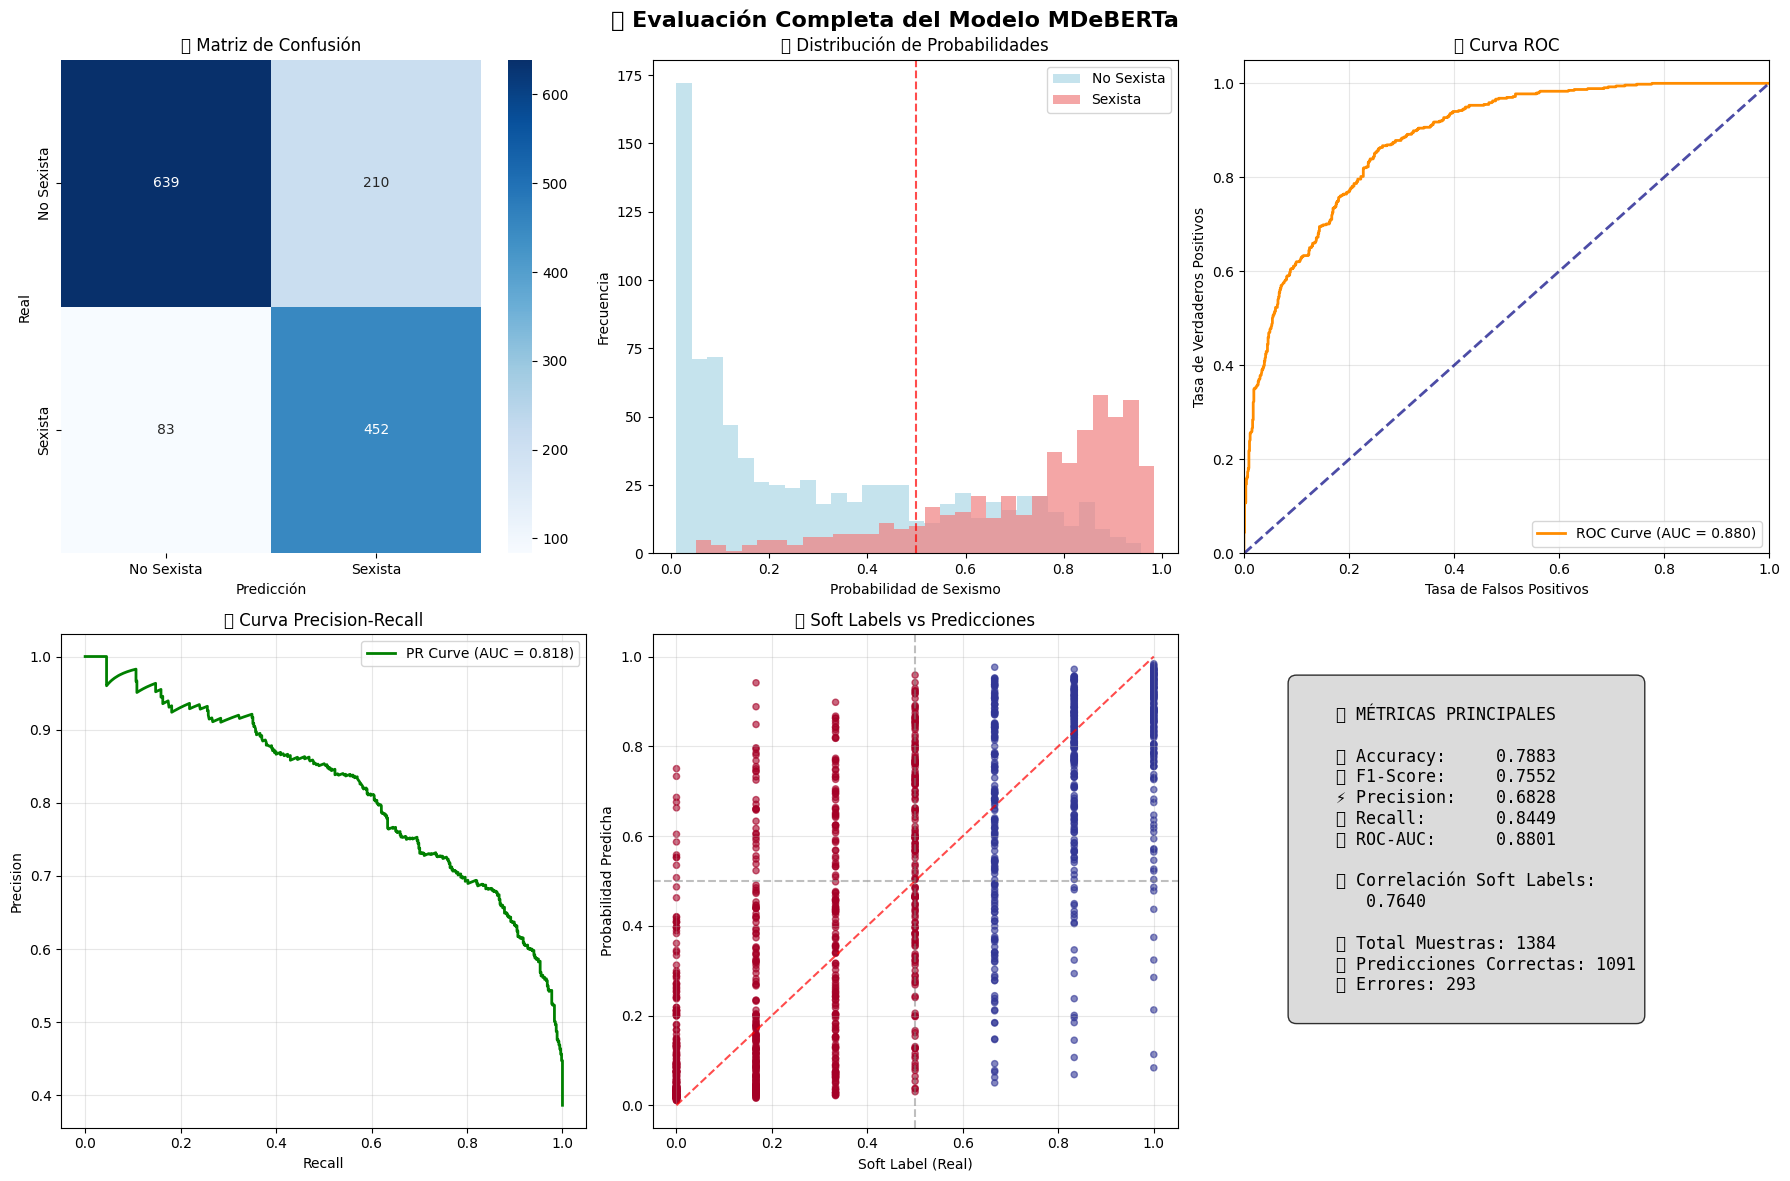

📊 Visualizaciones guardadas en: ./results_hybrid/evaluation_plots.png

📋 ESTADÍSTICAS ADICIONALES:
   📊 Muestras totales evaluadas: 1384
   ✅ Predicciones correctas: 1091
   ❌ Errores totales: 293
   🎯 Confianza promedio: 0.7958

✅ Evaluación completa finalizada exitosamente!


In [95]:
# 📊 VISUALIZACIONES DE LA EVALUACIÓN

print("📊 GENERANDO VISUALIZACIONES DE EVALUACIÓN...")

def create_evaluation_plots(evaluation_df, final_metrics, save_path):
    """Crear visualizaciones completas de la evaluación"""
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('🎯 Evaluación Completa del Modelo MDeBERTa', fontsize=16, fontweight='bold')
    
    # 1. MATRIZ DE CONFUSIÓN
    ax1 = axes[0, 0]
    cm = confusion_matrix(evaluation_df['y_true'], evaluation_df['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['No Sexista', 'Sexista'],
                yticklabels=['No Sexista', 'Sexista'])
    ax1.set_title('🔢 Matriz de Confusión')
    ax1.set_xlabel('Predicción')
    ax1.set_ylabel('Real')
    
    # 2. DISTRIBUCIÓN DE PROBABILIDADES
    ax2 = axes[0, 1]
    ax2.hist(evaluation_df[evaluation_df['y_true']==0]['y_prob'], 
             alpha=0.7, label='No Sexista', bins=30, color='lightblue')
    ax2.hist(evaluation_df[evaluation_df['y_true']==1]['y_prob'], 
             alpha=0.7, label='Sexista', bins=30, color='lightcoral')
    ax2.set_title('📈 Distribución de Probabilidades')
    ax2.set_xlabel('Probabilidad de Sexismo')
    ax2.set_ylabel('Frecuencia')
    ax2.legend()
    ax2.axvline(x=0.5, color='red', linestyle='--', alpha=0.7)
    
    # 3. CURVA ROC
    ax3 = axes[0, 2]
    fpr, tpr, _ = roc_curve(evaluation_df['y_true'], evaluation_df['y_prob'])
    auc_score = auc(fpr, tpr)
    ax3.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC Curve (AUC = {auc_score:.3f})')
    ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.7)
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlabel('Tasa de Falsos Positivos')
    ax3.set_ylabel('Tasa de Verdaderos Positivos')
    ax3.set_title('📊 Curva ROC')
    ax3.legend(loc="lower right")
    ax3.grid(True, alpha=0.3)
    
    # 4. PRECISION-RECALL CURVE
    ax4 = axes[1, 0]
    precision, recall, _ = precision_recall_curve(evaluation_df['y_true'], evaluation_df['y_prob'])
    pr_auc = auc(recall, precision)
    ax4.plot(recall, precision, color='green', lw=2,
             label=f'PR Curve (AUC = {pr_auc:.3f})')
    ax4.set_xlabel('Recall')
    ax4.set_ylabel('Precision')
    ax4.set_title('🎯 Curva Precision-Recall')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. SOFT LABELS VS PREDICCIONES
    ax5 = axes[1, 1]
    ax5.scatter(evaluation_df['soft_label'], evaluation_df['y_prob'], 
                alpha=0.6, s=20, c=evaluation_df['y_true'], cmap='RdYlBu')
    ax5.plot([0, 1], [0, 1], 'r--', alpha=0.7)
    ax5.set_xlabel('Soft Label (Real)')
    ax5.set_ylabel('Probabilidad Predicha')
    ax5.set_title('🎲 Soft Labels vs Predicciones')
    ax5.grid(True, alpha=0.3)
    
    # Agregar líneas de referencia
    ax5.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    ax5.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
    
    # 6. MÉTRICAS RESUMEN
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    # Crear texto con métricas principales
    metrics_text = f"""
    🏆 MÉTRICAS PRINCIPALES
    
    📊 Accuracy:     {final_metrics['accuracy']:.4f}
    🎯 F1-Score:     {final_metrics['f1_score']:.4f}
    ⚡ Precision:    {final_metrics['precision']:.4f}
    🔍 Recall:       {final_metrics['recall']:.4f}
    📈 ROC-AUC:      {final_metrics['roc_auc']:.4f}
    
    🎲 Correlación Soft Labels:
       {final_metrics['correlation_soft_labels']:.4f}
    
    📦 Total Muestras: {len(evaluation_df)}
    ✅ Predicciones Correctas: {(evaluation_df['y_true'] == evaluation_df['y_pred']).sum()}
    ❌ Errores: {(evaluation_df['y_true'] != evaluation_df['y_pred']).sum()}
    """
    
    ax6.text(0.1, 0.9, metrics_text, transform=ax6.transAxes, fontsize=12,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📊 Visualizaciones guardadas en: {save_path}")

# GENERAR VISUALIZACIONES
if 'evaluation_df' in locals() and 'final_metrics' in locals():
    # Crear visualizaciones
    plots_path = f"{manager.paths['output_dir']}/evaluation_plots.png"
    create_evaluation_plots(evaluation_df, final_metrics, plots_path)
    

    
    # Mostrar estadísticas adicionales
    print("\n📋 ESTADÍSTICAS ADICIONALES:")
    print(f"   📊 Muestras totales evaluadas: {len(evaluation_df)}")
    print(f"   ✅ Predicciones correctas: {(evaluation_df['y_true'] == evaluation_df['y_pred']).sum()}")
    print(f"   ❌ Errores totales: {(evaluation_df['y_true'] != evaluation_df['y_pred']).sum()}")
    print(f"   🎯 Confianza promedio: {np.maximum(evaluation_df['y_prob'], 1-evaluation_df['y_prob']).mean():.4f}")
    
    # Análisis de distribución por idioma si está disponible
    if 'lang' in evaluation_df.columns:
        print(f"\n🌍 DISTRIBUCIÓN POR IDIOMA:")
        lang_stats = evaluation_df.groupby('lang').agg({
            'y_true': 'count',
            'y_pred': lambda x: (x == evaluation_df.loc[x.index, 'y_true']).mean()
        }).round(4)
        lang_stats.columns = ['Muestras', 'Accuracy']
        print(lang_stats)
    
    print("\n✅ Evaluación completa finalizada exitosamente!")
    
else:
    print("⚠️  Ejecuta primero la celda de evaluación anterior")

In [96]:
# 🔍 ANÁLISIS DE CASOS ESPECÍFICOS Y RECOMENDACIONES

print("🔍 ANÁLISIS DETALLADO DE CASOS ESPECÍFICOS")
print("="*60)

def analyze_specific_cases(evaluation_df, test_df, n_examples=5):
    """Analizar casos específicos para entender el comportamiento del modelo"""
    
    if len(test_df) != len(evaluation_df):
        print("⚠️  No se puede realizar análisis de casos específicos (datasets no coinciden)")
        return
    
    # Combinar datos para análisis
    analysis_df = evaluation_df.copy()
    analysis_df['text_clean'] = test_df['text_clean'].values
    analysis_df['id_EXIST'] = test_df['id_EXIST'].values
    if 'lang' not in analysis_df.columns:
        analysis_df['lang'] = test_df['lang'].values
    
    print(f"\n✅ Datos combinados para análisis: {len(analysis_df)} muestras")
    
    # 1. CASOS PERFECTAMENTE CLASIFICADOS CON ALTA CONFIANZA
    print(f"\n🎯 1. CASOS PERFECTAMENTE CLASIFICADOS (Alta confianza):")
    perfect_mask = (analysis_df['y_true'] == analysis_df['y_pred']) & \
                   (np.maximum(analysis_df['y_prob'], 1-analysis_df['y_prob']) > 0.9)
    
    if perfect_mask.sum() > 0:
        perfect_cases = analysis_df[perfect_mask].sample(min(n_examples, perfect_mask.sum()), random_state=42)
        print(f"   📊 Total casos perfectos: {perfect_mask.sum()} ({perfect_mask.mean()*100:.1f}%)")
        
        for idx, (_, row) in enumerate(perfect_cases.iterrows()):
            confidence = max(row['y_prob'], 1-row['y_prob'])
            label_text = "SEXISTA" if row['y_true'] else "NO SEXISTA"
            print(f"\n   {idx+1}. [{row['lang'].upper()}] {label_text} (conf: {confidence:.3f})")
            print(f"      '{row['text_clean'][:100]}{'...' if len(row['text_clean']) > 100 else ''}'")
            print(f"      Soft label: {row['soft_label']:.3f} → Predicción: {row['y_prob']:.3f}")
    
    # 2. ERRORES CON ALTA CONFIANZA (CASOS MÁS PROBLEMÁTICOS)
    print(f"\n❌ 2. ERRORES CON ALTA CONFIANZA (Casos problemáticos):")
    error_mask = (analysis_df['y_true'] != analysis_df['y_pred']) & \
                 (np.maximum(analysis_df['y_prob'], 1-analysis_df['y_prob']) > 0.8)
    
    if error_mask.sum() > 0:
        error_cases = analysis_df[error_mask].sample(min(n_examples, error_mask.sum()), random_state=42)
        print(f"   📊 Total errores alta confianza: {error_mask.sum()} ({error_mask.mean()*100:.1f}%)")
        
        for idx, (_, row) in enumerate(error_cases.iterrows()):
            confidence = max(row['y_prob'], 1-row['y_prob'])
            real_label = "SEXISTA" if row['y_true'] else "NO SEXISTA"
            pred_label = "SEXISTA" if row['y_pred'] else "NO SEXISTA"
            print(f"\n   {idx+1}. [{row['lang'].upper()}] Real: {real_label} vs Pred: {pred_label} (conf: {confidence:.3f})")
            print(f"      '{row['text_clean'][:100]}{'...' if len(row['text_clean']) > 100 else ''}'")
            print(f"      Soft label: {row['soft_label']:.3f} → Predicción: {row['y_prob']:.3f}")
    
    # 3. CASOS AMBIGUOS (SOFT LABELS CERCA DE 0.5)
    print(f"\n🤔 3. CASOS AMBIGUOS (Soft labels cerca de 0.5):")
    ambiguous_mask = (analysis_df['soft_label'] > 0.3) & (analysis_df['soft_label'] < 0.7)
    
    if ambiguous_mask.sum() > 0:
        ambiguous_cases = analysis_df[ambiguous_mask].sample(min(n_examples, ambiguous_mask.sum()), random_state=42)
        print(f"   📊 Total casos ambiguos: {ambiguous_mask.sum()} ({ambiguous_mask.mean()*100:.1f}%)")
        
        for idx, (_, row) in enumerate(ambiguous_cases.iterrows()):
            confidence = max(row['y_prob'], 1-row['y_prob'])
            correct = "✅" if row['y_true'] == row['y_pred'] else "❌"
            print(f"\n   {idx+1}. [{row['lang'].upper()}] {correct} Ambiguo (soft: {row['soft_label']:.3f})")
            print(f"      '{row['text_clean'][:100]}{'...' if len(row['text_clean']) > 100 else ''}'")
            print(f"      Predicción: {row['y_prob']:.3f} (conf: {confidence:.3f})")
    
    # 4. COMPARACIÓN ENTRE IDIOMAS
    print(f"\n🌍 4. COMPARACIÓN ENTRE IDIOMAS:")
    for lang in ['es', 'en']:
        lang_data = analysis_df[analysis_df['lang'] == lang]
        if len(lang_data) > 0:
            lang_accuracy = (lang_data['y_true'] == lang_data['y_pred']).mean()
            lang_confidence = np.maximum(lang_data['y_prob'], 1-lang_data['y_prob']).mean()
            lang_correlation = np.corrcoef(lang_data['soft_label'], lang_data['y_prob'])[0,1]
            
            print(f"\n   📊 {lang.upper()}:")
            print(f"      Muestras: {len(lang_data)}")
            print(f"      Accuracy: {lang_accuracy:.4f}")
            print(f"      Confianza promedio: {lang_confidence:.4f}")
            print(f"      Correlación soft labels: {lang_correlation:.4f}")
    
    return analysis_df

def generate_model_recommendations(final_metrics, evaluation_df):
    """Generar recomendaciones basadas en la evaluación"""
    
    print(f"\n💡 RECOMENDACIONES PARA MEJORAR EL MODELO:")
    print("="*50)
    
    # Análisis de F1-Score
    f1_score = final_metrics['f1_score']
    if f1_score > 0.8:
        print("🎉 EXCELENTE: F1-Score > 0.8")
        print("   ✅ El modelo tiene un rendimiento excelente")
    elif f1_score > 0.7:
        print("👍 BUENO: F1-Score > 0.7")
        print("   🔧 Considera ajustar hiperparámetros para mejorar")
    else:
        print("⚠️  NECESITA MEJORA: F1-Score < 0.7")
        print("   🔧 Requiere optimización significativa")
    
    # Análisis de correlación con soft labels
    correlation = final_metrics['correlation_soft_labels']
    if correlation < 0.6:
        print(f"\n📊 CORRELACIÓN BAJA con soft labels ({correlation:.3f})")
        print("   💡 Recomendaciones:")
        print("   - Ajustar la función de pérdida para soft labels")
        print("   - Considerar usar temperatura scaling")
        print("   - Revisar el preprocesamiento de datos")
    
    # Análisis de balance de clases
    accuracy = final_metrics['accuracy']
    f1 = final_metrics['f1_score']
    if abs(accuracy - f1) > 0.1:
        print(f"\n⚖️  DESBALANCE detectado (Accuracy: {accuracy:.3f}, F1: {f1:.3f})")
        print("   💡 Recomendaciones:")
        print("   - Usar class weights en la función de pérdida")
        print("   - Considerar técnicas de oversampling/undersampling")
        print("   - Ajustar el threshold de clasificación")
    
    # Análisis de confianza
    if 'y_prob' in evaluation_df.columns:
        confidence = np.maximum(evaluation_df['y_prob'], 1-evaluation_df['y_prob'])
        low_confidence_pct = (confidence < 0.7).mean()
        
        if low_confidence_pct > 0.3:
            print(f"\n🎯 BAJA CONFIANZA en {low_confidence_pct*100:.1f}% de predicciones")
            print("   💡 Recomendaciones:")
            print("   - Entrenar más épocas")
            print("   - Usar data augmentation")
            print("   - Considerar ensemble methods")
    
    # Recomendaciones generales
    print(f"\n🚀 RECOMENDACIONES GENERALES:")
    print("   1. 📊 Monitorear métricas en conjunto de validación separado")
    print("   2. 🔄 Experimentar con diferentes learning rates")
    print("   3. 🎯 Probar different números de capas congeladas")
    print("   4. 📈 Considerar curriculum learning con soft labels")
    print("   5. 🔍 Analizar errores por categorías semánticas")
    
    print(f"\n✨ PRÓXIMOS PASOS SUGERIDOS:")
    print("   🎯 1. Ajustar threshold de clasificación si es necesario")
    print("   📊 2. Validar en conjunto de test independiente")
    print("   🚀 3. Preparar modelo para deployment en Azure ML")
    print("   📝 4. Documentar hallazgos y métricas finales")

# EJECUTAR ANÁLISIS COMPLETO
if 'evaluation_df' in locals() and 'test_df' in locals() and 'final_metrics' in locals():
    
    # Análisis de casos específicos
    detailed_analysis = analyze_specific_cases(evaluation_df, test_df, n_examples=3)
    
    # Generar recomendaciones
    generate_model_recommendations(final_metrics, evaluation_df)
    
    # Resumen final
    print(f"\n🏆 RESUMEN FINAL DE EVALUACIÓN:")
    print("="*50)
    print(f"📊 Modelo: MDeBERTa-v3-base con Soft Labels")
    print(f"🎯 F1-Score: {final_metrics['f1_score']:.4f}")
    print(f"📈 Accuracy: {final_metrics['accuracy']:.4f}")
    print(f"🔄 ROC-AUC: {final_metrics['roc_auc']:.4f}")
    print(f"🎲 Correlación Soft Labels: {final_metrics['correlation_soft_labels']:.4f}")
    print(f"📦 Muestras evaluadas: {len(evaluation_df)}")
    print(f"✅ Estado: {'LISTO PARA PRODUCCIÓN' if final_metrics['f1_score'] > 0.75 else 'REQUIERE OPTIMIZACIÓN'}")
    
    print(f"\n💾 Todos los resultados guardados en: {manager.paths['output_dir']}")
    
else:
    print("⚠️  Ejecuta primero las celdas de evaluación anteriores")

print("="*60)

🔍 ANÁLISIS DETALLADO DE CASOS ESPECÍFICOS

✅ Datos combinados para análisis: 1384 muestras

🎯 1. CASOS PERFECTAMENTE CLASIFICADOS (Alta confianza):
   📊 Total casos perfectos: 436 (31.5%)

   1. [EN] SEXISTA (conf: 0.943)
      'Fat Men and slim women handshake'
      Soft label: 1.000 → Predicción: 0.943

   2. [EN] SEXISTA (conf: 0.931)
      'You can pinpoint where I stopped caring about my health tonight. It wasn't when I decided country gr...'
      Soft label: 0.833 → Predicción: 0.931

   3. [EN] NO SEXISTA (conf: 0.978)
      '// suggestive ? nsfw ?Choke me like you hate me, but you love meLow-key wanna date me when you fuck ...'
      Soft label: 0.000 → Predicción: 0.022

❌ 2. ERRORES CON ALTA CONFIANZA (Casos problemáticos):
   📊 Total errores alta confianza: 64 (4.6%)

   1. [EN] Real: NO SEXISTA vs Pred: SEXISTA (conf: 0.865)
      '@samuelanjorin__ Haha, this thing, so far it's a woman driving, you find that your anger just assuag...'
      Soft label: 0.500 → Predicción:

📊 BÚSQUEDA DEL MEJOR UMBRAL:
   🎯 Mejor F1-Score: 0.7591
   📈 Umbral óptimo:  0.48
   (Con Precisión: 0.6795 y Recall: 0.8598)


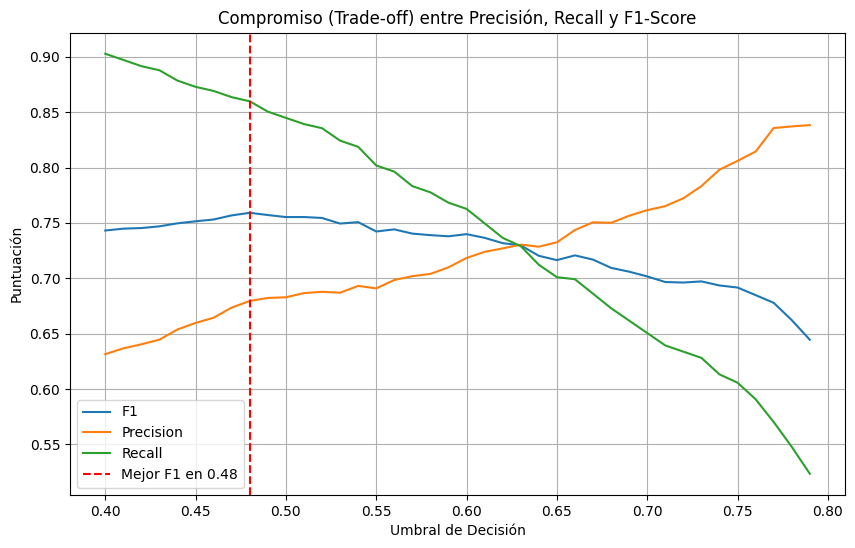

In [98]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Usar el DataFrame de evaluación que ya creaste
y_true = evaluation_df['y_true']
y_prob = evaluation_df['y_prob']

# Probar umbrales desde 0.4 hasta 0.8 en pequeños pasos
thresholds = np.arange(0.4, 0.8, 0.01)
scores = []

for thresh in thresholds:
    preds = (y_prob > thresh).astype(int)
    f1 = f1_score(y_true, preds)
    precision = precision_score(y_true, preds)
    recall = recall_score(y_true, preds)
    scores.append([thresh, f1, precision, recall])

# Encontrar el mejor resultado
scores_df = pd.DataFrame(scores, columns=['Threshold', 'F1', 'Precision', 'Recall'])
best_threshold = scores_df.sort_values(by='F1', ascending=False).iloc[0]

print("📊 BÚSQUEDA DEL MEJOR UMBRAL:")
print("="*40)
print(f"   🎯 Mejor F1-Score: {best_threshold['F1']:.4f}")
print(f"   📈 Umbral óptimo:  {best_threshold['Threshold']:.2f}")
print(f"   (Con Precisión: {best_threshold['Precision']:.4f} y Recall: {best_threshold['Recall']:.4f})")
print("="*40)

# Graficar los resultados
scores_df.plot(x='Threshold', y=['F1', 'Precision', 'Recall'], figsize=(10, 6))
plt.title('Compromiso (Trade-off) entre Precisión, Recall y F1-Score')
plt.ylabel('Puntuación')
plt.xlabel('Umbral de Decisión')
plt.grid(True)
plt.axvline(x=best_threshold['Threshold'], color='r', linestyle='--', label=f'Mejor F1 en {best_threshold["Threshold"]:.2f}')
plt.legend()
plt.show()